## 들어가며

ocr을 직접 만들어 보겠습니다.
detection은 keras-ocr을 활용하고, recognition은 직접 만들어봅니다.

## Overall structure of OCR

우리가 만들고자 하느 OCR은 이미지 속에서 영문을 Bounding box로 찾아내고 그 Bounding box 내에 어떤 Text가 포함되는지 알 수 있는 시스템 입니다.  
이미지 속에서 문자 영역을 찾아내는 것인 text detection은 이전에 봤던 방법 중 segmentation 기반의 CRAFT를 활용한 keras-ocr을 활용할 예정입니다.  

recognition 모델은 직접 만들어 보도록 하겠습니다.  

keras-ocr에도 recognition이 있는데 Convolution layer와 RNN을 결합하고 CTC로 학습된 CRNN이 사용되었습니다.

*2019년까지의 모델의 변천사*
* https://arxiv.org/pdf/1904.01906.pdf  


위 논문에서 가장 성능이 좋은 recognition 모델과 keras-ocr의 모델은 어떤점이 다를까요?
> 첫 번째로 입력 이미지 변환 단계에서는 모델의 앞에서 글자를 Thin plate spline Transformation을 해주는 TPS 모듈이 붙고, 마지막 Text 출력 단계에서는 Bidirectional LSTM 뒤로 Attention decoder가 붙습니다.

## Dataset for OCR

OCR은 데이터셋에 필요한 텍스트 정보를 사람이 직접 입력해야 하는 번거로움이 있습니다.  
따라서 OCR 데이터를 대량으로 만들려면 큰 비용이 듭니다.  
데이터 문제를 해결하기 위한 방법 중 하나로는 컴퓨터로 대량의 문자 이미지 데이터를 만들어내는 방법입니다.  
직접 문자 데이터를 생서앟게 되면, 원하는 언어를 원하는 폰트와 원하는 배치 및 크기로 문자 이미지를 대량으로 만들어 낼 수 있다는 장점이 있습니다.  

위와 같은 논문들에서는 Recognition model의 정량적인 평가를 위해 MJSynth 와 SynthText라는 데이터셋을 활용합니다.


recognition model의 학습을 위해 MJSynth를 사용해보도록 하겠습니다.

https://www.dropbox.com/sh/i39abvnefllx2si/AAAbAYRvxzRp3cIE5HzqUw3ra?dl=0  

위 링크의 data_lmdb_release.zip 내에 있는 MJ 데이터만 활용할 예정입니다.

## recognition model (1)

Text recognition 모델을 직접 만들어 보도록 하겠습니다.  
Recognition 모델은 2015년에 발표된 아래 논문에서 처음 소개된 CRNN 구조를 활용해 만들어보도록 합시다.

* [논문링크](https://arxiv.org/pdf/1507.05717.pdf)

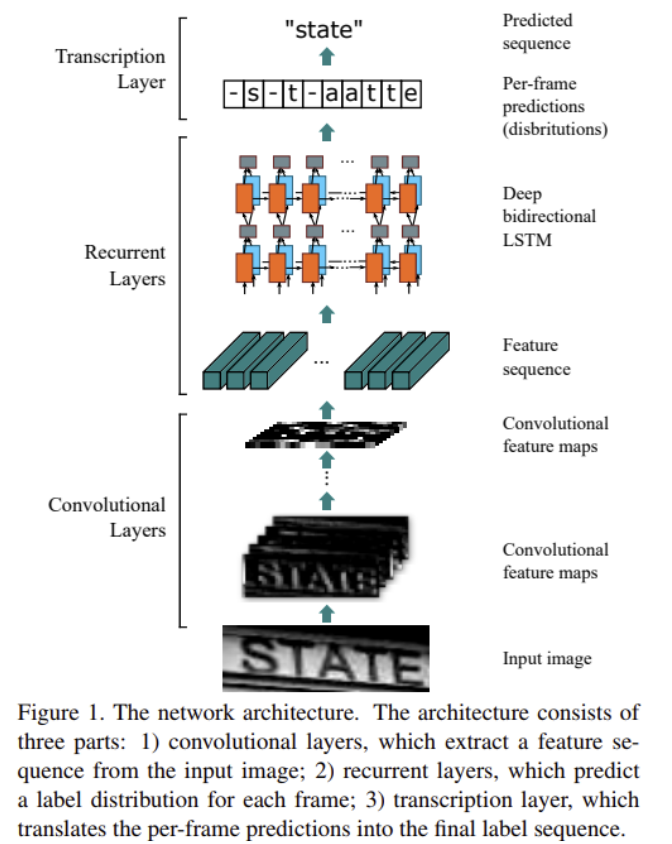

CRNN의 구조는 위 그림에서 아래부터 올라가는 순서로 보면 됩니다.  

입력 이미지를 convolution layer를 통해 Feature를 추출하여 추출된 Feature를 얻어냅니다.  

Recurrent Layer는 추출된 Feature의 전체적인 context를 파악하고 다양한 output의 크기에 대응이 가능합니다.  

끝으로, Transcription layer는 step마다 어떤 character의 확률이 높은지 예측합니다.

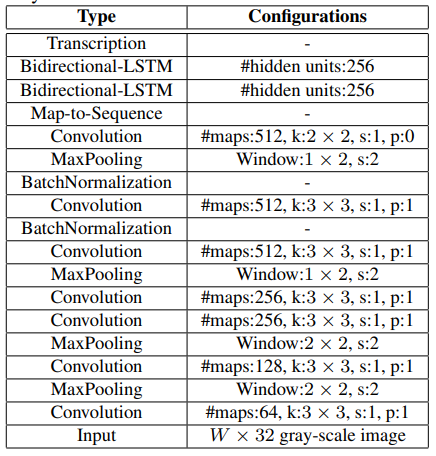

> 영문 대문자와 숫자를 인식하기 위해서는 알파벳 26가지와 숫자 10가지, 총 36개의 class가 필요합니다. 공백을 포함한다면 총 37가지가 됩니다.

먼저 lmdb를 사용할 예정입니다.  
오늘 다룰 데이터셋이 lmdb(mdb)파일로 이루어져 있습니다.



In [1]:
import re
import six
import math
import lmdb
import os
import numpy as np
import tensorflow as tf

from PIL import Image

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model

BATCH_SIZE = 128
HOME_DIR = '/content/drive/MyDrive/node'

TRAIN_DATA_PATH = HOME_DIR+'/data/MJ/MJ_train'
VALID_DATA_PATH = HOME_DIR+'/data/MJ/MJ_valid'
TEST_DATA_PATH = HOME_DIR+'/data/MJ/MJ_test'

print(TRAIN_DATA_PATH)

/content/drive/MyDrive/node/data/MJ/MJ_train


## Recognition model(2), Input Image

데이터셋 안에 들어있는 이미지가 실제로 어떻게 생겼는지 확인해봅시다.


original image width:72, height:31
target_img_size:(74, 32)
display img shape:(74, 32, 3)
label:Lube


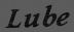

original image width:82, height:31
target_img_size:(84, 32)
display img shape:(84, 32, 3)
label:Spencerian


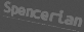

original image width:115, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:accommodatingly


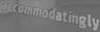

original image width:140, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:CARPENTER


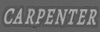

In [2]:
from IPython.display import display

# env에 데이터를 불러올게요
# lmdb에서 데이터를 불러올 때 env라는 변수명을 사용하는게 일반적이에요
env = lmdb.open(TRAIN_DATA_PATH, 
                max_readers=32, 
                readonly=True, 
                lock=False, 
                readahead=False, 
                meminit=False)

# 불러온 데이터를 txn(transaction)이라는 변수를 통해 엽니다
# 이제 txn변수를 통해 직접 데이터에 접근 할 수 있어요
with env.begin(write=False) as txn:
    for index in range(1, 5):
        # index를 이용해서 라벨 키와 이미지 키를 만들면
        # txn에서 라벨과 이미지를 읽어올 수 있어요
        label_key = 'label-%09d'.encode() % index
        label = txn.get(label_key).decode('utf-8')
        img_key = 'image-%09d'.encode() % index
        imgbuf = txn.get(img_key)
        buf = six.BytesIO()
        buf.write(imgbuf)
        buf.seek(0)

        # 이미지는 버퍼를 통해 읽어오기 때문에 
        # 버퍼에서 이미지로 변환하는 과정이 다시 필요해요
        try:
            img = Image.open(buf).convert('RGB')

        except IOError:
            img = Image.new('RGB', (100, 32))
            label = '-'

        # 원본 이미지 크기를 출력해 봅니다
        width, height = img.size
        print('original image width:{}, height:{}'.format(width, height))
        
        # 이미지 비율을 유지하면서 높이를 32로 바꿀거에요
        # 하지만 너비를 100보다는 작게하고 싶어요
        target_width = min(int(width*32/height), 100)
        target_img_size = (target_width,32)        
        print('target_img_size:{}'.format(target_img_size))        
        img = np.array(img.resize(target_img_size)).transpose(1,0,2)

        # 이제 높이가 32로 일정한 이미지와 라벨을 함께 출력할 수 있어요       
        print('display img shape:{}'.format(img.shape))
        print('label:{}'.format(label))
        display(Image.fromarray(img.transpose(1,0,2).astype(np.uint8)))

이제 imdb를 활용하여 케라스 모델 학습용 MJSynth 데이터셋 클래스를 구현합니다.

dataset_path 는 읽어들일 데이터셋의 경로입니다.

label_converter는 아래에서 문자를 미리 정의된 index로 변환해주는 converter로 직접 구현하도록 합니다.

In [3]:
class MJDatasetSequence(Sequence):
    # 객체를 초기화 할 때 lmdb를 열어 env에 준비해둡니다
    # 또, lmdb에 있는 데이터 수를 미리 파악해둡니다
    def __init__(self, 
                 dataset_path,
                 label_converter,
                 batch_size=1,
                 img_size=(100,32),
                 max_text_len=22,
                 is_train=False,
                 character='') :
        
        self.label_converter = label_converter
        self.batch_size = batch_size
        self.img_size = img_size
        self.max_text_len = max_text_len
        self.character = character
        self.is_train = is_train
        self.divide_length = 100

        self.env = lmdb.open(dataset_path, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
        with self.env.begin(write=False) as txn:
            self.num_samples = int(txn.get('num-samples'.encode()))
            self.index_list = [index + 1 for index in range(self.num_samples)]
        

    def __len__(self):
        return math.ceil(self.num_samples/self.batch_size/self.divide_length)
    
    # index에 해당하는 image와 label을 읽어옵니다
    # 위에서 사용한 코드와 매우 유사합니다
    # label을 조금 더 다듬는 것이 약간 다릅니다
    def _get_img_label(self, index):
        with self.env.begin(write=False) as txn:
            label_key = 'label-%09d'.encode() % index
            label = txn.get(label_key).decode('utf-8')
            img_key = 'image-%09d'.encode() % index
            imgbuf = txn.get(img_key)

            buf = six.BytesIO()
            buf.write(imgbuf)
            buf.seek(0)
            try:
                img = Image.open(buf).convert('RGB')

            except IOError:
                img = Image.new('RGB', self.img_size)
                label = '-'
            width, height = img.size
            
            target_width = min(int(width*self.img_size[1]/height), self.img_size[0])
            target_img_size = (target_width, self.img_size[1])
            img = np.array(img.resize(target_img_size)).transpose(1,0,2)
            # label을 약간 더 다듬습니다
            label = label.upper()
            out_of_char = f'[^{self.character}]'
            label = re.sub(out_of_char, '', label)
            label = label[:self.max_text_len]

        return (img, label)
    
    # __getitem__은 약속되어있는 메서드입니다
    # 이 부분을 작성하면 slice할 수 있습니다
    # 자세히 알고 싶다면 아래 문서를 참고하세요
    # https://docs.python.org/3/reference/datamodel.html#object.__getitem__
    # 
    # 1. idx에 해당하는 index_list만큼 데이터를 불러
    # 2. image와 label을 불러오고 
    # 3. 사용하기 좋은 inputs과 outputs형태로 반환합니다
    def __getitem__(self, idx):
        # 1.
        batch_indicies = self.index_list[
            idx*self.batch_size:
            (idx+1)*self.batch_size
        ]
        input_images = np.zeros([self.batch_size, *self.img_size, 3])
        labels = np.zeros([self.batch_size, self.max_text_len], dtype='int64')

        input_length = np.ones([self.batch_size], dtype='int64') * self.max_text_len
        label_length = np.ones([self.batch_size], dtype='int64')

        # 2.
        for i, index in enumerate(batch_indicies):
            img, label = self._get_img_label(index)
            encoded_label = self.label_converter.encode(label)
            # 인코딩 과정에서 '-'이 추가되면 max_text_len보다 길어질 수 있어요
            if len(encoded_label) > self.max_text_len:
                continue
            width = img.shape[0]
            input_images[i,:width,:,:] = img
            labels[i,0:len(encoded_label)] = encoded_label
            label_length[i] = len(encoded_label)
        
        # 3.
        inputs = {
            'input_image': input_images,
            'label': labels,
            'input_length': input_length,
            'label_length': label_length,
        }
        outputs = {'ctc': np.zeros([self.batch_size, 1])}

        return inputs, outputs


이미지의 데이터를 img , label의 쌍으로 가져오는 부분은 _get_img_label() 메소드에서 반영되었습니다. 그리고 model.fit()에서 호출되는 _ _ getitem _ _() 메소드에서 배치 단위만큼 _get_img_label을 통해 가져온 데이터셋을 반환합니다.

## Recognition model(3) , Encode

이전 스텝에서 살펴본 바에 의하면, Label이 우리가 읽을 수 있는 평문 Text로 이루어져 있었습니다.  

그러나 이것은 모델을 학습하기 위해 적절한 형태가 아닙니다. 따라서 각 Chracter를 class로 생각하고 이를 step에 따른 class index 로 변환해서 encode해주어야 합니다.  

이를 위한 LabelConverter클래스를 작성해 봅니다.  



In [4]:
class LabelConverter(object):

     def __init__(self, character):
         self.character = "-" + character
         self.label_map = dict()
         for i, char in enumerate(self.character):
             self.label_map[char] = i

     def encode(self, text):
         encoded_label = []
         # 같은 문자가 연속으로 나오는 경우 그 사이에 공백을 넣어준다.
         for i,t in enumerate(text):
             if i > 0 and t == text[i - 1]:
                 encoded_label.append(0)    
             encoded_label.append(self.label_map[t])

         return np.array(encoded_label)

     def decode(self, encoded_label):
         target_characters = list(self.character)
         decoded_label = ""
         for encode in encoded_label:
             decoded_label += self.character[encode]
         return decoded_label

In [5]:
NUMBERS = "0123456789"
ENG_CHAR_UPPER = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
TARGET_CHARACTERS = ENG_CHAR_UPPER + NUMBERS

label_converter = LabelConverter(TARGET_CHARACTERS)

encdoded_text = label_converter.encode('HELLO')
print("Encdoded_text: ", encdoded_text)
decoded_text = label_converter.decode(encdoded_text)
print("Decoded_text: ", decoded_text)

Encdoded_text:  [ 8  5 12  0 12 15]
Decoded_text:  HEL-LO


## Recognition model(4) , Build CRNN model

이제 입력과 출력을 준비했으니 모델을 만들 차례입니다.  
keras에서 제공하는 K.ctc_batch_cost()를 활용하여 loss를 계산하도록 ctc_lambda_func를 아래와 같이 만듭니다.

In [6]:
def ctc_lambda_func(args): # CTC loss를 계산하기 위한 Lambda 함수
    labels, y_pred, label_length, input_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

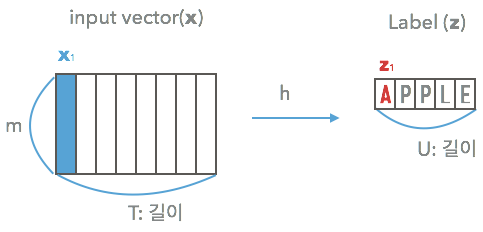

CTC loss 를 활용해야 하는 모델이 위 그림과 같은 상황을 다루기 위한 것임을 알고있습니다.  

입력의 길이 T와 label의 길이 U의 단위가 일치하지 않을때, 라벨은 APPLE이지만 모델의 예측은 AAAPPPPLLLLEE처럼 나올 수 있습니다.

> 만약 모델이 AAAPPPPLLLLEE를 출력했다면 추론의 결과는 APLE일지 APPLE일지 구분이 불가능합니다.  
그러므로 추론 결과가 APPLE이 되게 하려면 이미지의 라벨은 AP-PLE로 보정해주어야 합니다.  
이러한 이유로 LabelConverter.encode()메소드에 공백문자 처리 로직을 포함했습니다.

In [7]:
def build_crnn_model(input_shape=(100,32,3), characters=TARGET_CHARACTERS):
    num_chars = len(characters)+2
    image_input = layers.Input(shape=input_shape, dtype='float32', name='input_image')
    
    # Build CRNN model
    # 위 논문에서 봤던 모델 구조에 맞게 구축합니다.
    conv = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(image_input)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)     
    feature = layers.Conv2D(512, (2, 2), activation='relu', kernel_initializer='he_normal')(conv)
    sequnce = layers.Reshape(target_shape=(24, 512))(feature)
    sequnce = layers.Dense(64, activation='relu')(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    y_pred = layers.Dense(num_chars, activation='softmax', name='output')(sequnce)

    labels = layers.Input(shape=[22], dtype='int64', name='label')
    input_length = layers.Input(shape=[1], dtype='int64', name='input_length')
    label_length = layers.Input(shape=[1], dtype='int64', name='label_length')
    loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name="ctc")(
        [labels, y_pred, label_length, input_length]
    )
    model_input = [image_input, labels, input_length, label_length]
    model = Model(
        inputs=model_input,
        outputs=loss_out
    )
    return model

## Recognition model(5) , Train & Inference


앞에서 정의한 MJDatasetSequence로 데이터를 적절히 분리하여 구성된 데이터셋을 통해 학습시켜봅니다.

In [8]:
# 데이터셋과 모델을 준비합니다
train_set = MJDatasetSequence(TRAIN_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS, is_train=True)
val_set = MJDatasetSequence(VALID_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()

# 모델을 컴파일 합니다
optimizer = tf.keras.optimizers.Adadelta(lr=0.1, clipnorm=5)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adadelta.py:74: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adadelta, self).__init__(name, **kwargs)


In [9]:
# 훈련이 빨리 끝날 수 있도록 ModelCheckPoint와 EarlyStopping을 사용합니다
checkpoint_path = HOME_DIR + '/model_checkpoint.hdf5'
ckp = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, monitor='val_loss',
    verbose=1, save_best_only=True, save_weights_only=True
)
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=4, verbose=0, mode='min'
)
model.fit(train_set,
          steps_per_epoch=len(train_set),
          epochs=20,
          validation_data=val_set,
          validation_steps=len(val_set),
          callbacks=[ckp, earlystop])

Epoch 1/20
565/565 [==============================] - ETA: 0s - loss: 25.7000
Epoch 1: val_loss improved from inf to 24.96029, saving model to /content/drive/MyDrive/node/model_checkpoint.hdf5
565/565 [==============================] - 133s 201ms/step - loss: 25.7000 - val_loss: 24.9603
Epoch 2/20
565/565 [==============================] - ETA: 0s - loss: 16.0038
Epoch 2: val_loss improved from 24.96029 to 10.48826, saving model to /content/drive/MyDrive/node/model_checkpoint.hdf5
565/565 [==============================] - 102s 180ms/step - loss: 16.0038 - val_loss: 10.4883
Epoch 3/20
565/565 [==============================] - ETA: 0s - loss: 7.4521
Epoch 3: val_loss improved from 10.48826 to 6.68125, saving model to /content/drive/MyDrive/node/model_checkpoint.hdf5
565/565 [==============================] - 102s 180ms/step - loss: 7.4521 - val_loss: 6.6813
Epoch 4/20
565/565 [==============================] - ETA: 0s - loss: 5.2916
Epoch 4: val_loss improved from 6.68125 to 5.45526, s

In [11]:
# 다음은 학습된 모델의 가중치가 저장된 경로입니다
checkpoint_path = HOME_DIR + '/model_checkpoint.hdf5'

# 데이터셋과 모델을 불러옵니다
test_set = MJDatasetSequence(TEST_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()
model.load_weights(checkpoint_path)

# crnn 모델은 입력이 복잡한 구조이므로 그대로 사용할 수가 없습니다
# 그래서 crnn 모델의 입력중 'input_image' 부분만 사용한 모델을 새로 만들겁니다
# inference 전용 모델이에요 
input_data = model.get_layer('input_image').output
y_pred = model.get_layer('output').output
model_pred = Model(inputs=input_data, outputs=y_pred)

Result: 	 SLINKING9999999999999999


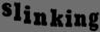

Result: 	 ALEPPO99999999999999999


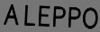

Result: 	 RWANDA999999999999999999


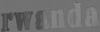

Result: 	 NATHANS99999999999999999


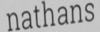

Result: 	 HALLEO99999999999999999


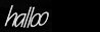

Result: 	 HURLS9999999999999999999


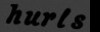

Result: 	 DOWNSIZE9999999999999999


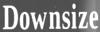

Result: 	 ROBOTIC99999999999999999


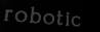

Result: 	 SLOPPY99999999999999999


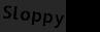

Result: 	 HERMITE99999999999999999


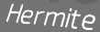

In [12]:
from IPython.display import display

# 모델이 inference한 결과를 글자로 바꿔주는 역할을 합니다
# 코드 하나하나를 이해하기는 조금 어려울 수 있습니다
def decode_predict_ctc(out, chars = TARGET_CHARACTERS):
    results = []
    indexes = K.get_value(
        K.ctc_decode(
            out, input_length=np.ones(out.shape[0]) * out.shape[1],
            greedy=False , beam_width=5, top_paths=1
        )[0][0]
    )[0]
    text = ""
    for index in indexes:
        text += chars[index]
    results.append(text)
    return results

# 모델과 데이터셋이 주어지면 inference를 수행합니다
# index개 만큼의 데이터를 읽어 모델로 inference를 수행하고
# 결과를 디코딩해 출력해줍니다
def check_inference(model, dataset, index = 5):
    for i in range(index):
        inputs, outputs = dataset[i]
        img = dataset[i][0]['input_image'][0:1,:,:,:]
        output = model.predict(img)
        result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
        print("Result: \t", result)
        display(Image.fromarray(img[0].transpose(1,0,2).astype(np.uint8)))

check_inference(model_pred, test_set, index=10)

# 프로젝트 : End-to-End OCR

In [14]:
!pip install keras_ocr

     |████████████████████████████████| 41 kB 446 kB/s 
     |████████████████████████████████| 603 kB 45.4 MB/s 
     |████████████████████████████████| 900 kB 65.6 MB/s 
     |████████████████████████████████| 9.5 MB 56.8 MB/s 
     |████████████████████████████████| 50 kB 9.2 MB/s 


In [17]:
import tensorflow as tf
import numpy as np
import PIL
import cv2
import keras_ocr
from PIL import ImageDraw

In [16]:
from keras_ocr.detection import Detector

SAMPLE_IMG_PATH = HOME_DIR + '/data/sample.jpg'

detector = Detector()

Looking for /root/.keras-ocr/craft_mlt_25k.h5


In [18]:
def detect_text(img_path):
    img_pil = Image.open(img_path)
    img_pil = img_pil.resize((640, 640))
    img_draw=ImageDraw.Draw(img_pil)
    result_img = img_pil
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img)
    img = tf.image.resize(img, (640, 640))
    img = img[tf.newaxis, :, :, :]
        
    det_result = detector.detect(img.numpy())
        
    ocr_result = det_result[0]
    cropped_imgs = []
    for text_result in ocr_result:
        img_draw.polygon(text_result, outline='red')
        x_min = text_result[:,0].min() - 5
        x_max = text_result[:,0].max() + 5
        y_min = text_result[:,1].min() - 5
        y_max = text_result[:,1].max() + 5
        word_box = [x_min, y_min, x_max, y_max]
        cropped_imgs.append(img_pil.crop(word_box))


    return result_img, cropped_imgs

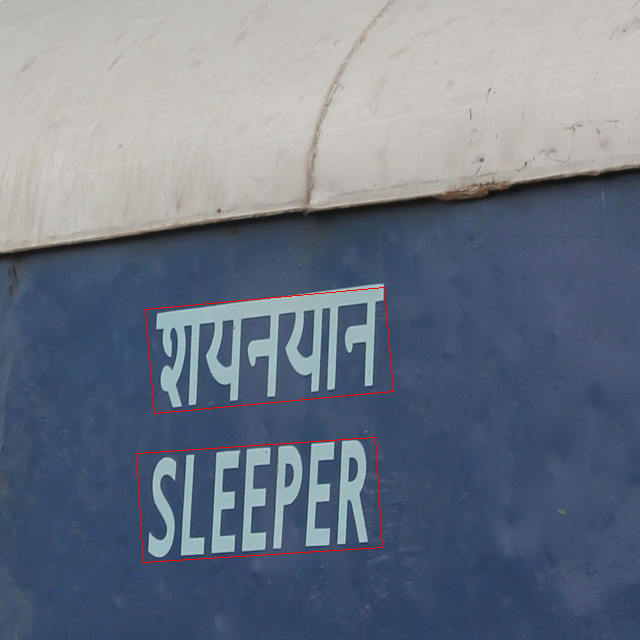

In [19]:
img_pil, cropped_img = detect_text(SAMPLE_IMG_PATH)
display(img_pil)

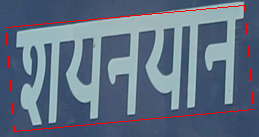

In [20]:
cropped_img[0]

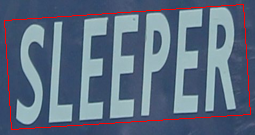

In [21]:
cropped_img[1]

In [24]:
def recognize_img(pil_img, input_img_size=(100,32)):
    # TODO: 잘려진 단어 이미지를 인식하는 코드를 작성하세요!
    img = pil_img.resize(input_img_size)
    np_img = np.array(img)
    np_img = np.transpose(np_img, (1, 0, 2))
    np_img = np_img[np.newaxis, :, :, :]
    output = model_pred.predict(np_img)
    result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
    print("Result: \t", result)
    display(Image.fromarray(np.array(img).astype(np.uint8)))

Result: 	 PRARUFT99999999999999999


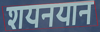

Result: 	 SLEEPER9999999999999999


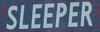

In [25]:
for _img in cropped_img:
    recognize_img(_img)